In [27]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np

In [28]:
data_path = "tests/data"

data_paths = os.listdir(data_path)
data_paths = list(filter(lambda x: x.startswith("qmdmckp"), data_paths))
data_paths[0:10]

['qmdmckp_100_100_1_0_1.txt',
 'qmdmckp_100_100_1_0_10.txt',
 'qmdmckp_100_100_1_0_2.txt',
 'qmdmckp_100_100_1_0_3.txt',
 'qmdmckp_100_100_1_0_5.txt',
 'qmdmckp_100_100_1_0_6.txt',
 'qmdmckp_100_100_1_0_7.txt',
 'qmdmckp_100_100_1_0_8.txt',
 'qmdmckp_100_100_1_0_9.txt',
 'qmdmckp_100_25_1_0_1.txt']

In [29]:
results = []
for datum_path in data_paths:
    datum_fullpath = os.path.join(data_path, datum_path)
    with open(datum_fullpath) as file:
        datum = json.load(file)
        datum["name"] = datum_path
        results.append(datum)
print(results[0].keys())

dict_keys(['x', 'y', 'lambda', 'zu', 'metrics', 'name'])


### Load greedy results

In [30]:
greedy_path = "tests/profits/Greedy.txt"
profits = dict()

with open(greedy_path) as file:
    for line in file:
        name, profit = line.split()
        if not name.startswith("qmdmckp"):
            continue
        profit = float(profit)
        profits[name] = {"greedy": profit}

### Load admm results

In [31]:
admm_path = "tests/profits/Admm with 3 block.txt"

with open(admm_path) as file:
    for line in file:
        name, profit = line.split()
        if not name.startswith("qmdmckp"):
            continue
        profit = float(profit)
        profits[name]["admm"] = profit

In [32]:
### Add to results
for result in results:
    name = result["name"]
    cur_profits = profits[name]
    for key, value in cur_profits.items():
        result[key] = value
print(results[0].keys())

dict_keys(['x', 'y', 'lambda', 'zu', 'metrics', 'name', 'greedy', 'admm'])


### Lets draw!

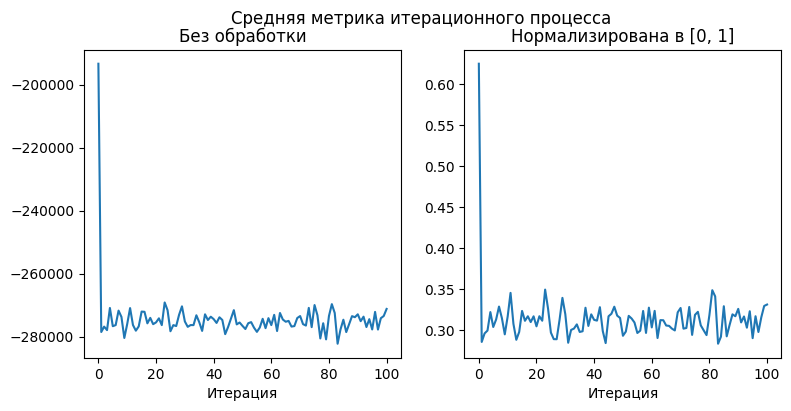

In [33]:
data = results[0]["metrics"]
mean_raw_data = np.zeros_like(data)
mean_normal_data = np.zeros_like(data)

def normal(xs):
    cur_min = min(xs)
    cur_max = max(xs)
    return list(map(lambda x: (x - cur_min) / (cur_max - cur_min), xs))

for result in results:    
    mean_raw_data += result["metrics"]
    mean_normal_data += normal(result["metrics"])

mean_raw_data /= len(results)
mean_normal_data /= len(results)

plt.figure(figsize=(9, 4))

# Raw 
plt.subplot(121)
plt.plot(mean_raw_data)
plt.xlabel("Итерация")
plt.title("Без обработки")

# Normal
plt.subplot(122)
plt.plot(mean_normal_data)
plt.xlabel("Итерация")
plt.title("Нормализирована в [0, 1]")

plt.suptitle("Средняя метрика итерационного процесса")
plt.savefig("images/MeanMetric_All.png")
plt.show()

### Plots without initial values

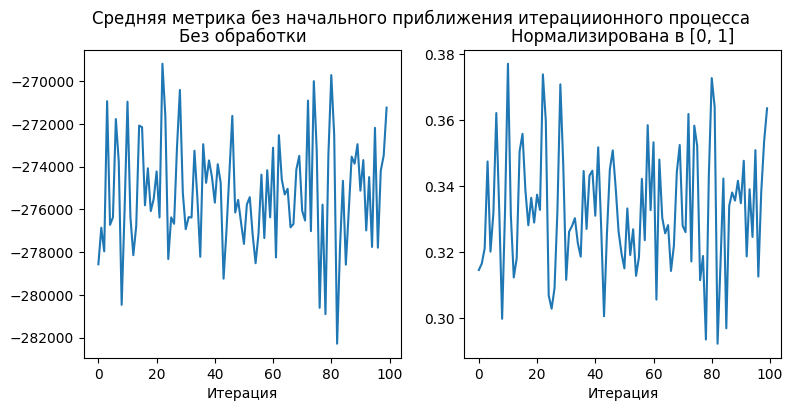

In [34]:
shifted_mean_raw_data = np.zeros_like(data[1:])
shifted_mean_normal_data = np.zeros_like(data[1:])

for result in results:
    shifted_mean_raw_data += result["metrics"][1:]
    shifted_mean_normal_data += normal(result["metrics"][1:])
    

shifted_mean_raw_data /= len(results)
shifted_mean_normal_data /= len(results)

plt.figure(figsize=(9, 4))

# Raw 
plt.subplot(121)
plt.plot(shifted_mean_raw_data)
plt.xlabel("Итерация")
plt.title("Без обработки")


# Normal
plt.subplot(122)
plt.plot(shifted_mean_normal_data)
plt.xlabel("Итерация")
plt.title("Нормализирована в [0, 1]")

plt.suptitle("Средняя метрика без начального приближения итерациионного процесса")
plt.savefig("images/MeanMetric_WithoutFirst.png")
plt.show()

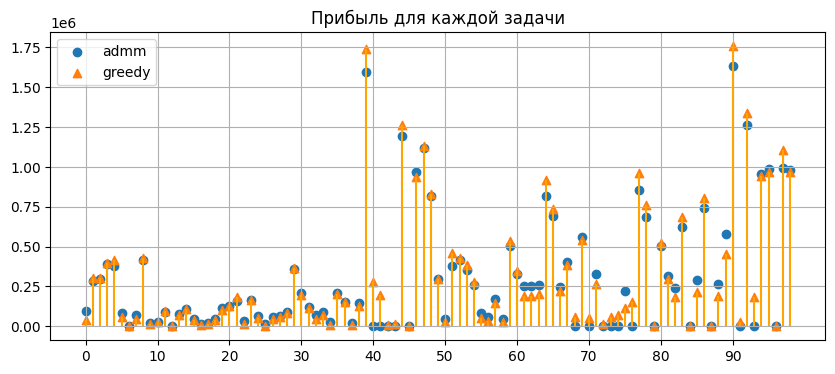

In [35]:
greedy_profits = []
admm_profits = []

plt.figure(figsize=(10, 4))

for result in results:
    greedy_profits.append(result["greedy"])
    admm_profits.append(result["admm"])

xs = np.arange(len(results))


plt.grid()

plt.scatter(xs, admm_profits, label="admm")
plt.scatter(xs, greedy_profits, label="greedy", marker='^')
plt.vlines(xs, [0], greedy_profits, color="orange")
plt.title("Прибыль для каждой задачи")
plt.legend()
plt.xticks(np.arange(0, len(xs), 10))
plt.savefig("images/Profits_All.png")
plt.show()

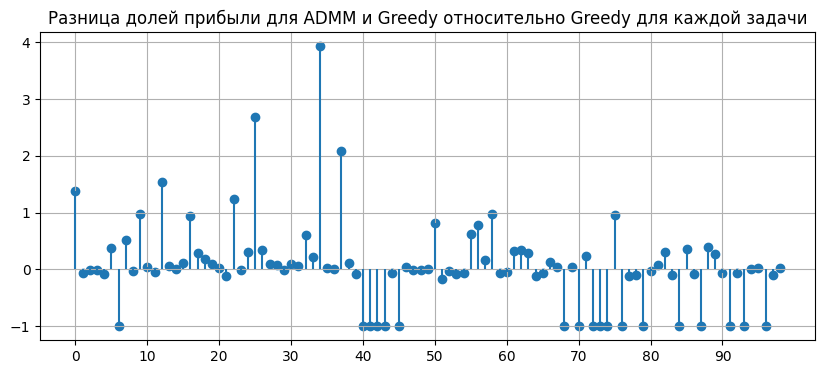

In [36]:
plt.figure(figsize=(10, 4))

delta_admm_greedy = []

for result in results:
    delta_admm_greedy.append((result["admm"] - result["greedy"]) / result["greedy"])

xs = np.arange(len(results))


plt.grid()
plt.scatter(xs, delta_admm_greedy)
plt.vlines(xs, [0], delta_admm_greedy)
plt.title("Разница долей прибыли для ADMM и Greedy относительно Greedy для каждой задачи")
plt.xticks(np.arange(0, len(xs), 10))
plt.savefig("images/Profits_Ratio_Admm_Greedy.png")
plt.show()

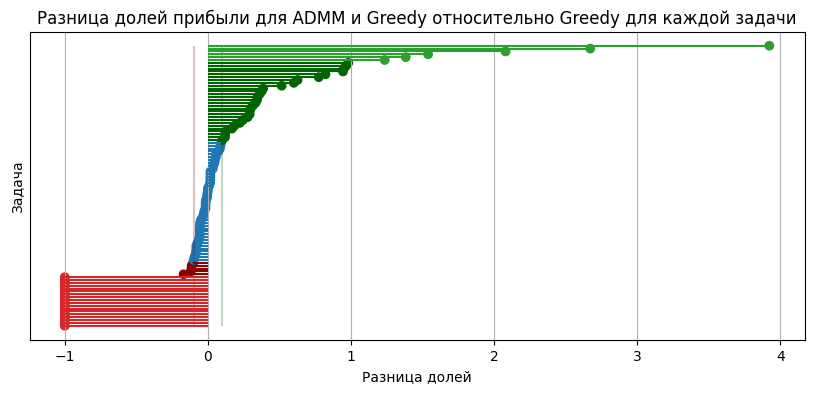

In [37]:
# Добавить граффик красивее, где повернут на 90 и как-то кумулитирует

sorted_delta_admm_greedy = sorted(delta_admm_greedy)

def get_color(x):
    if (x == -1):
        return "tab:red"
    if (x >= 1):
        return "tab:green"
    if (x >= 0.1):
        return "darkgreen"
    if (x <= -0.1):
        return "darkred"
    return "tab:blue"

plt.figure(figsize=(10, 4))
plt.grid()
color = [get_color(x) for x in sorted_delta_admm_greedy]
plt.vlines([-0.1, 0.1], [0], [len(sorted_delta_admm_greedy) - 1], color=["darkred", "darkgreen"], alpha=0.25)
plt.scatter(sorted_delta_admm_greedy, xs, color=color)
plt.hlines(xs, [0], sorted_delta_admm_greedy, color=color)

plt.title("Разница долей прибыли для ADMM и Greedy относительно Greedy для каждой задачи")
plt.xlabel("Разница долей")
plt.ylabel("Задача")
plt.yticks([])
plt.savefig("images/Profits_Sorted_Ratio_Admm_Greedy.png")
plt.show()

In [38]:
np.mean(delta_admm_greedy)

0.058471077886917674